In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import os

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')


<IPython.core.display.Javascript object>

## Introduccion

El objetivo de este trabajo es ofrecer una metodología sencilla para determinar de una manera práctica qué constuituye el **Aglomerado Gran Buenos Aires (AGBA)**. El Instituto Nacional de Estadísticas y Censos de Argentina (INDEC) [establece](http://www.indec.gov.ar/nuevaweb/cuadros/4/folleto%20gba.pdf) una distinción entre este y el **Gran Buenos Aires (AGBA)**: *"La diferencia entre el Gran Buenos Aires y el Aglomerado Gran Buenos Aires es que el primero alude a un conjunto de partidos (más la Ciudad de Buenos Aires) tomados en su totalidad, mientras el
segundo alude a un área que se va moviendo con el tiempo y que incluye a algunos partidos de manera
parcial.*

Esta naturaleza cambiante del envolvente de población 
oner link y decir que uno es administrativo y otro urbano dinamico cambiante. OPM como fuente cambiante crowdsourcing


In [3]:
#departamentos AGBA segun INDEC
departamentos = {
    'Comuna 1':'02001',
    'Comuna 2':'02002',
    'Comuna 3':'02003',
    'Comuna 4':'02004',
    'Comuna 5':'02005',
    'Comuna 6':'02006',
    'Comuna 7':'02007',
    'Comuna 8':'02008',
    'Comuna 9':'02009',
    'Comuna 10':'02010',
    'Comuna 11':'02011',
    'Comuna 12':'02012',
    'Comuna 13':'02013',
    'Comuna 14':'02014',
    'Comuna 15':'02015',
    'ALMIRANTE BROWN':'06028',
    'AVELLANEDA':'06035',
    'BERAZATEGUI':'06091',
    'ESCOBAR':'06252',
    'ESTEBAN ECHEVERRIA':'06260',
    'EZEIZA':'06270',
    'FLORENCIO VARELA':'06274',
    'GENERAL RODRIGUEZ':'06364',
    'GENERAL SAN MARTIN':'06371',
    'HURLINGHAM':'06408',
    'ITUZAINGO':'06410',
    'JOSE C PAZ':'06412',
    'LA MATANZA':'06427',
    'LANUS':'06434',
    'LOMAS DE ZAMORA':'06490',
    'MALVINAS ARGENTINAS':'06515',
    'MARCOS PAZ':'06525',
    'MERLO':'06539',
    'MORENO':'06560',
    'MORON':'06568',
    'PILAR':'06638',
    'PRESIDENTE PERON':'06648',
    'QUILMES':'06658',
    'SAN FERNANDO':'06749',
    'SAN ISIDRO':'06756',
    'SAN MIGUEL':'06760',
    'SAN VICENTE':'06778',
    'TIGRE':'06805',
    'TRES DE FEBRERO':'06840',
    'VICENTE LOPEZ':'06861'
}

departamentosName = {
    '02001':'Comuna 1',
    '02002':'Comuna 2',
    '02003':'Comuna 3',
    '02004':'Comuna 4',
    '02005':'Comuna 5',
    '02006':'Comuna 6',
    '02007':'Comuna 7',
    '02008':'Comuna 8',
    '02009':'Comuna 9',
    '02010':'Comuna 10',
    '02011':'Comuna 11',
    '02012':'Comuna 12',
    '02013':'Comuna 13',
    '02014':'Comuna 14',
    '02015':'Comuna 15',
    '06028':'ALMIRANTE BROWN',
    '06035':'AVELLANEDA',
    '06091':'BERAZATEGUI',
    '06252':'ESCOBAR',
    '06260':'ESTEBAN ECHEVERRIA',
    '06270':'EZEIZA',
    '06274':'FLORENCIO VARELA',
    '06364':'GENERAL RODRIGUEZ',
    '06371':'GENERAL SAN MARTIN',
    '06408':'HURLINGHAM',
    '06410':'ITUZAINGO',
    '06412':'JOSE C PAZ',
    '06427':'LA MATANZA',
    '06434':'LANUS',
    '06490':'LOMAS DE ZAMORA',
    '06515':'MALVINAS ARGENTINAS',
    '06525':'MARCOS PAZ',
    '06539':'MERLO',
    '06560':'MORENO',
    '06568':'MORON',
    '06638':'PILAR',
    '06648':'PRESIDENTE PERON',
    '06658':'QUILMES',
    '06749':'SAN FERNANDO',
    '06756':'SAN ISIDRO',
    '06760':'SAN MIGUEL',
    '06778':'SAN VICENTE',
    '06805':'TIGRE',
    '06840':'TRES DE FEBRERO',
    '06861':'VICENTE LOPEZ'
}


In [4]:
#CARGO CARTOGRAFIA NACIONAL NO OFICIAL
agba = gpd.GeoDataFrame.from_file('/home/pipe/Downloads/paisNoOficial/rad_paisp.shp')
agba['LINK'] = agba.PROV + agba.DEPTO + agba.FRAC + agba.RADIO
agba.drop([u'DEPTO', u'FRAC', u'PERIMETER', u'PROV', u'RADIO', u'RADPAIS_',
       u'RADPAIS_ID'],axis=1,inplace=True)

#CREO EL CODIGO DEPARTAMENTO PARA FILTRAR LOS PERTENECIENTES A PARTIDOS DEL AGBA
agba['DEPARTAMENTO'] = agba.LINK.map(lambda x: x[0:5])

#ELIMINAMOS LOS DEPARTAMENTOS QUE NO SEAN DE AGBA SEGUN INDEC
agba = agba.loc[agba.DEPARTAMENTO.isin(departamentos.values()),:]

#LOS RADIOS FALTANTES DE CABA SON URBANOS
agba.TIPO.fillna('U',inplace=True)

#ELIMINAMOS LOS RADIOS RURALES
agba = agba.loc[agba.TIPO!='R',:]

#AGREGAMOS ETIQUETAS A LOS DEPARTAMENTOS
deptos = []
for i in range(agba.shape[0]):
    deptos.append(departamentosName[agba.DEPARTAMENTO.iloc[i]])
agba['DEPTO_NAME'] = deptos
agba = agba.to_crs(epsg=22185)

agba.head()


,AREA,LINK,TIPO,geometry,DEPARTAMENTO,DEPTO_NAME
26688,16948780.0,062520101,M,"POLYGON ((5605573.523703439 6208535.44525929, ...",06252,ESCOBAR
26704,12351870.0,062520102,M,"POLYGON ((5606597.563514996 6207794.426813126,...",06252,ESCOBAR
26719,11063170.0,062520208,U,"POLYGON ((5608236.390336967 6207306.631047663,...",06252,ESCOBAR
26741,796720.3,062520201,U,"POLYGON ((5611075.149383005 6206034.538516479,...",06252,ESCOBAR
26747,2996825.0,062520202,U,"POLYGON ((5613709.611741914 6205445.958880841,...",06252,ESCOBAR


## load density

In [5]:
#esta data fue descargada desde la pagina oficial de indec 
#http://200.51.91.245/argbin/RpWebEngine.exe/PortalAction?&MODE=MAIN&BASE=CPV2010B&MAIN=WebServerMain.inl
#obteniendo listado por areas a nivel de radio censal
#sexo, con total de filas, para: 

#los 24 partidos del Gran Benos Aires
pbaPob = pd.read_csv('../dt/poblacionPBAcenso.csv')
pbaPob.LINK = pbaPob.LINK.map(lambda x: '0'+str(x))
print pbaPob.shape

#CABA 
cabaPob = pd.read_csv('../dt/poblacionCABAcenso.csv')
cabaPob.LINK = cabaPob.LINK.map(lambda x: '0'+str(x))
print cabaPob.shape

poblacion = cabaPob.append(pbaPob)
print poblacion.shape

(19552, 2)
(3553, 2)
(23105, 2)


In [6]:
agba = agba.merge(poblacion, on='LINK',how='left')


In [7]:
agba.loc[agba.LINK.duplicated(),:]

,AREA,LINK,TIPO,geometry,DEPARTAMENTO,DEPTO_NAME,Pob
2336,18459.31,020130104,U,"POLYGON ((5640843.337760887 6177613.239423731,...",02013,Comuna 13,763
3371,22525.75,020121607,U,"POLYGON ((5638863.653027886 6173784.750408883,...",02012,Comuna 12,754


In [8]:
agba['densidad'] = agba.Pob / agba.AREA
agba['densidad'] = pd.qcut(agba.densidad,10,labels=False)


In [9]:
pd.crosstab(agba.densidad,agba.TIPO)

TIPO,M,U
densidad,,
0,76,1269
1,0,1345
2,0,1344
3,0,1345
4,1,1343
5,0,1345
6,0,1344
7,0,1345
8,0,1344


In [10]:

mixYden = (agba.TIPO == 'M') | (agba.densidad == 0)
agba['mixYden'] =mixYden
agba.drop(['AREA','DEPARTAMENTO','Pob','TIPO','densidad'], axis=1,inplace=True)
agbaAltaDens = agba.loc[~agba.mixYden,:]
agbaBajaDens = agba.loc[agba.mixYden,:]

agba.head()

,LINK,geometry,DEPTO_NAME,mixYden
0,062520101,"POLYGON ((5605573.523703439 6208535.44525929, ...",ESCOBAR,True
1,062520102,"POLYGON ((5606597.563514996 6207794.426813126,...",ESCOBAR,True
2,062520208,"POLYGON ((5608236.390336967 6207306.631047663,...",ESCOBAR,True
3,062520201,"POLYGON ((5611075.149383005 6206034.538516479,...",ESCOBAR,True
4,062520202,"POLYGON ((5613709.611741914 6205445.958880841,...",ESCOBAR,True


## Load OSM

In [11]:
#download data
osmFile = os.path.expanduser('~')+'/Downloads/buenos-aires_argentina.osm2pgsql-shapefiles/buenos-aires_argentina_osm_line.shp'
if not os.path.isfile(osmFile):
    os.sys('wget https://s3.amazonaws.com/metro-extracts.mapzen.com/buenos-aires_argentina.osm2pgsql-shapefiles.zip')
    os.sys('unzip https://s3.amazonaws.com/metro-extracts.mapzen.com/buenos-aires_argentina.osm2pgsql-shapefiles.zip')



In [12]:
calles = gpd.read_file('/home/pipe/Downloads/buenos-aires_argentina.osm2pgsql-shapefiles/buenos-aires_argentina_osm_line.shp')
calles = calles.loc[:,['highway','geometry']]
mask =  (calles.highway == 'residential') | (calles.highway == 'unclassified') |  (calles.highway == 'living_street') 
calles = calles.loc[mask,:]
calles = calles.to_crs(epsg=22185)


In [13]:
calles['buffer'] = calles.geometry.buffer(100)
calles.drop(['geometry'],axis=1,inplace=True)
calles.columns = [u'highway', u'geometry']

# prueba con porciones

In [ ]:
# para cada radio, chequear :
# res_union = gpd.overlay(calleSola, radiosSel, how='intersection')
#esto me devuelve una base con tantos poligonos cmom


In [43]:
radiosSel = gpd.read_file('dataPrueba/radiosSeleccionados.shp')
calleConectada = gpd.read_file('dataPrueba/calleConConexion.shp')
calleConectada['buffer'] = calleConectada.geometry.buffer(70)
calleConectada.drop(['geometry'],axis=1,inplace=True)
calleConectada.columns = [u'highway', u'geometry']

calleAislada = gpd.read_file('dataPrueba/calleSinConexion.shp')
calleAislada['buffer'] = calleAislada.geometry.buffer(70)
calleAislada.drop(['geometry'],axis=1,inplace=True)
calleAislada.columns = [u'highway', u'geometry']

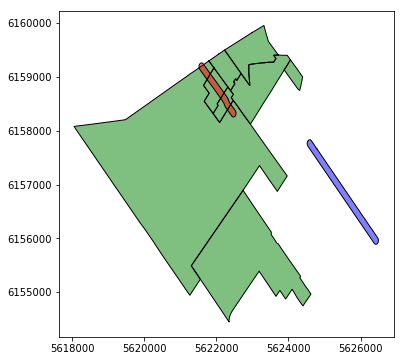

In [44]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
calleAislada.plot(ax=ax,color='blue')
calleConectada.plot(ax=ax,color='red')

In [45]:
intersec = gpd.overlay(radiosSel, calleConectada, how='intersection')
intersec

,AREA,DEPARTAMEN,DEPTO_NAME,LINK,Pob,TIPO,densidad,highway,geometry
0,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5621831.386868679 6159061.582841514,..."
1,297245.6,06539,MERLO,065391008,2204,U,3,residential,"POLYGON ((5621789.358866802 6159012.434962539,..."
2,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5622304.19733424 6158390.687202398, ..."
3,169436.9,06539,MERLO,065391009,1766,U,5,residential,"POLYGON ((5622352.559752863 6158443.872580742,..."


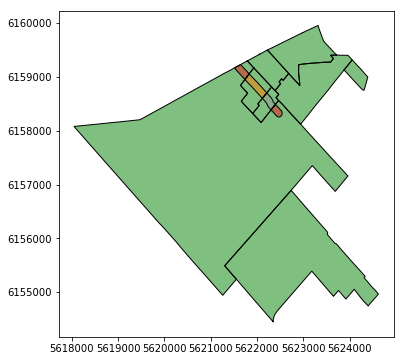

In [46]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
intersec.plot(ax=ax,column='LINK')


In [47]:
noIntersec = gpd.overlay(radiosSel, calleAislada, how='intersection')


In [48]:
noIntersec.shape

(0, 0)

In [49]:
calleConectada2 = gpd.read_file('dataPrueba/calleConConexion2.shp')
calleConectada2['buffer'] = calleConectada2.geometry.buffer(70)
calleConectada2.drop(['geometry'],axis=1,inplace=True)
calleConectada2.columns = [u'highway', u'geometry']



In [50]:
radiosSel

,AREA,DEPARTAMEN,DEPTO_NAME,LINK,Pob,TIPO,densidad,geometry
0,709438.6,06539,MERLO,065391011,1698,M,0,"POLYGON ((5622991.846299809 6159829.863916122,..."
1,318848.7,06539,MERLO,065391010,1850,U,2,"POLYGON ((5622057.632108648 6159428.089684312,..."
2,10753800.0,06539,MERLO,065391007,2913,M,0,"POLYGON ((5621790.619307964 6159302.969603975,..."
3,985014.2,06539,MERLO,065391016,1801,M,0,"POLYGON ((5623717.811691104 6159413.054642096,..."
4,135624.1,06539,MERLO,065391015,1181,M,4,"POLYGON ((5623881.460787947 6159134.908213038,..."
5,297245.6,06539,MERLO,065391008,2204,U,3,"POLYGON ((5621931.441590016 6159172.910726232,..."
6,169436.9,06539,MERLO,065391009,1766,U,5,"POLYGON ((5622315.43644484 6158817.795655366, ..."
7,3579931.0,06427,LA MATANZA,064278412,1452,M,0,"POLYGON ((5622739.405051569 6156895.223836675,..."


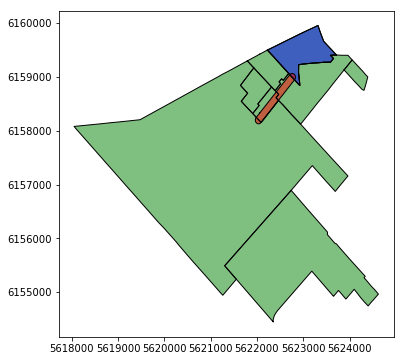

In [51]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
radiosSel.loc[radiosSel.LINK == '065391011',:].plot(ax=ax,color='blue')
calleConectada2.plot(ax=ax,color='RED')


In [52]:
intersec2 = gpd.overlay(radiosSel, calleConectada2, how='intersection')
intersec2

,AREA,DEPARTAMEN,DEPTO_NAME,LINK,Pob,TIPO,densidad,highway,geometry
0,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5621985.381953466 6158252.55699361, ..."
1,169436.9,06539,MERLO,065391009,1766,U,5,residential,"POLYGON ((5621991.465134294 6158246.843687637,..."
2,985014.2,06539,MERLO,065391016,1801,M,0,residential,"POLYGON ((5622423.833162273 6158721.66510212, ..."
3,709438.6,06539,MERLO,065391011,1698,M,0,residential,"POLYGON ((5622709.271911588 6159046.506834115,..."


In [53]:
appenDF = intersec2.append(intersec)
appenDF

,AREA,DEPARTAMEN,DEPTO_NAME,LINK,Pob,TIPO,densidad,highway,geometry
0,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5621985.381953466 6158252.55699361, ..."
1,169436.9,06539,MERLO,065391009,1766,U,5,residential,"POLYGON ((5621991.465134294 6158246.843687637,..."
2,985014.2,06539,MERLO,065391016,1801,M,0,residential,"POLYGON ((5622423.833162273 6158721.66510212, ..."
3,709438.6,06539,MERLO,065391011,1698,M,0,residential,"POLYGON ((5622709.271911588 6159046.506834115,..."
0,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5621831.386868679 6159061.582841514,..."
1,297245.6,06539,MERLO,065391008,2204,U,3,residential,"POLYGON ((5621789.358866802 6159012.434962539,..."
2,10753800.0,06539,MERLO,065391007,2913,M,0,residential,"POLYGON ((5622304.19733424 6158390.687202398, ..."
3,169436.9,06539,MERLO,065391009,1766,U,5,residential,"POLYGON ((5622352.559752863 6158443.872580742,..."


In [54]:
appenDFdiss = appenDF.dissolve(by='LINK')


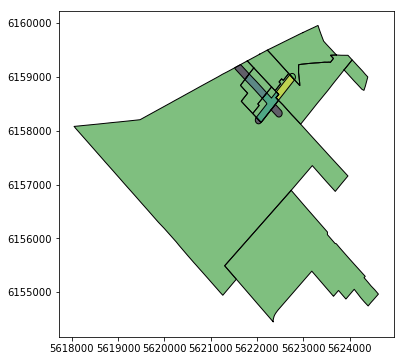

In [55]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)
radiosSel.plot(ax=ax,color='green')
appenDFdiss.plot(ax=ax)

# hacer el loop

In [14]:
calles.drop(['highway'],axis=1,inplace=True)
calles['calleID'] = calles.index

In [15]:
#spatial join
calles = gpd.sjoin(calles, agbaBajaDens.loc[:,['geometry','LINK']], how="inner", op='intersects')
calles.reset_index(inplace=True)
calles.drop(['index','index_right'],axis=1,inplace=True)
calles.head()

/home/pipe/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:2287: RuntimeWarning: invalid value encountered in find_intersects (vectorized)
  outputs = ufunc(*inputs)


,geometry,calleID,LINK
0,"POLYGON ((5584404.629722874 6157245.409330949,...",277,063640504
1,"POLYGON ((5585797.157224065 6157690.710567379,...",279,063640504
2,"POLYGON ((5585766.893090877 6157819.541789982,...",280,063640504
3,"POLYGON ((5585824.361333102 6157929.274601583,...",281,063640504
4,"POLYGON ((5585928.447176262 6157857.453439912,...",282,063640504


In [ ]:
#caca = calles2.loc[calles2.calleID==311,:]
#caca.reset_index(inplace=True)
#caca.drop(['index','index_right'],axis=1,inplace=True)
#caca

In [22]:
'''
primerID = calles.calleID.unique()[0]
counter = 0
subset = calles.loc[calles.calleID==primerID,:]
unaLinea = subset.iloc[0:1,:]
conjuntoDeRadios = agbaBajaDens.loc[agbaBajaDens.LINK.isin(subset.LINK),:]
intercept = gpd.overlay(conjuntoDeRadios, unaLinea, how='intersection')
intercept.head()
primerID = calles.calleID.unique()[1]
subset = calles.loc[calles.calleID==primerID,:]
unaLinea = subset.iloc[0:1,:]
conjuntoDeRadios = agbaBajaDens.loc[agbaBajaDens.LINK.isin(subset.LINK),:]
tmp = gpd.overlay(conjuntoDeRadios, unaLinea, how='intersection')
intercept.append(tmp)
'''

,LINK,DEPTO_NAME,mixYden,calleID,LINK_2,geometry
0,063640504,GENERAL RODRIGUEZ,True,277,063640504,"POLYGON ((5585076.052959187 6158626.697466956,..."


In [56]:
agbaBajaDens.head()

,LINK,geometry,DEPTO_NAME,mixYden
0,062520101,"POLYGON ((5605573.523703439 6208535.44525929, ...",ESCOBAR,True
1,062520102,"POLYGON ((5606597.563514996 6207794.426813126,...",ESCOBAR,True
2,062520208,"POLYGON ((5608236.390336967 6207306.631047663,...",ESCOBAR,True
3,062520201,"POLYGON ((5611075.149383005 6206034.538516479,...",ESCOBAR,True
4,062520202,"POLYGON ((5613709.611741914 6205445.958880841,...",ESCOBAR,True


In [27]:
primerID = calles.calleID.unique()[0]
counter = 0
for i in calles.calleID.unique():
    subset = calles.loc[calles.calleID==i,:]
    unaLinea = subset.iloc[0:1,:]
    conjuntoDeRadios = agbaBajaDens.loc[agbaBajaDens.LINK.isin(subset.LINK),:]
    if i == primerID:
        intercept = gpd.overlay(conjuntoDeRadios, unaLinea, how='intersection')
    else:
        tmp = gpd.overlay(conjuntoDeRadios, unaLinea, how='intersection')
        intercept = intercept.append(tmp)
    counter += 1
        
    print '\r',"%",str((counter+1)*100./len(calles.calleID.unique()))[:4],

% 100.          0.32                     0.83           1.11            1.40                        2.08    2.21    2.34                           3.09               3.42          3.66            3.96           4.24                                      5.39                             6.24                                                  7.66              8.03                       8.61                 9.10           9.32              9.67                                10.5               10.9                11.3                    11.9                    12.5                        13.1                                14.0          14.3             14.5           14.7            15.0                  15.4      15.5         15.7         16.0                             16.6      16.8     16.9            17.2        17.4    17.5                 17.9                   18.3                  18.7            19.0       19.2                                19.8       19.9        20.2          

In [28]:
intercept.head()

,LINK,DEPTO_NAME,mixYden,calleID,LINK_2,geometry
0,063640504,GENERAL RODRIGUEZ,True,277,063640504,"POLYGON ((5585076.052959187 6158626.697466956,..."
0,063640504,GENERAL RODRIGUEZ,True,279,063640504,"POLYGON ((5585876.703430125 6157766.650889304,..."
0,063640504,GENERAL RODRIGUEZ,True,280,063640504,"POLYGON ((5585816.305761689 6157867.002179299,..."
0,063640504,GENERAL RODRIGUEZ,True,281,063640504,"POLYGON ((5585652.716804017 6158033.904114954,..."
0,063640504,GENERAL RODRIGUEZ,True,282,063640504,"POLYGON ((5585735.918334833 6157949.005015798,..."


In [80]:
intercept = intercept.loc[:,['LINK','geometry']]

In [81]:
linkConProblemas = []
for i in intercept.LINK.unique():
    try:
        intercept.loc[intercept.LINK==i,:].dissolve(by='LINK')
    except:
        linkConProblemas.append(i)

TopologyException: found non-noded intersection between LINESTRING (5.59847e+06 6.17144e+06, 5.59846e+06 6.17144e+06) and LINESTRING (5.59844e+06 6.17145e+06, 5.59857e+06 6.17141e+06) at 5598467.2086282168 6171438.6117269164
TopologyException: found non-noded intersection between LINESTRING (5.59847e+06 6.17144e+06, 5.59846e+06 6.17144e+06) and LINESTRING (5.59844e+06 6.17145e+06, 5.59857e+06 6.17141e+06) at 5598467.2086282168 6171438.6117269164
TopologyException: Directed Edge visited twice during ring-building at 5613217.3448867993 6184894.2529578889
TopologyException: Directed Edge visited twice during ring-building at 5613217.3448867993 6184894.2529578889
TopologyException: found non-noded intersection between LINESTRING (5.62408e+06 6.18908e+06, 5.62408e+06 6.18908e+06) and LINESTRING (5.62409e+06 6.18907e+06, 5.62405e+06 6.1891e+06) at 5624077.9095266806 6189080.6289979015
TopologyException: found non-noded intersection between LINESTRING (5.62408e+06 6.18908e+06, 5.62408e+06 6.1

In [82]:
linkConProblemas

[u'063640823', u'065151704', u'068050901']

In [87]:
intercepDissolve = gpd.GeoDataFrame(intercept.loc[~intercept.LINK.isin(linkConProblemas),['LINK','geometry']].groupby("LINK").geometry.agg(shapely.ops.unary_union).reset_index(), geometry="geometry", crs=agba.crs) 
#intercepDissolve = intercept.loc[~intercept.LINK.isin(linkConProblemas),['LINK','geometry']].dissolve(by='LINK')


In [88]:
intercepDissolve.reset_index().to_file('intercept')